In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# path = "https://raw.githubusercontent.com/mlguy001/gitTest/main/corporate_rating.csv"
path = "corporate_rating.csv"
df = pd.read_csv(path)

In [4]:
rank = {'D':0,'C':1,'CC':2,'CCC':3,'B':4,'BB':5,'BBB':6,'A':7,'AA':8,'AAA':9}
order = pd.DataFrame()
order["Rank"] = rank.values()
order.index = rank.keys()
order = pd.merge(order, df["Rating"].value_counts().rename("Frequency"), left_index=True, right_index=True, how="left")
order["Frequency"] = order["Frequency"].cumsum()

In [5]:
orderType = "Rank"
# orderType = "Frequency"
df["Score"] = df["Rating"].map(order[orderType])

**Distributions**

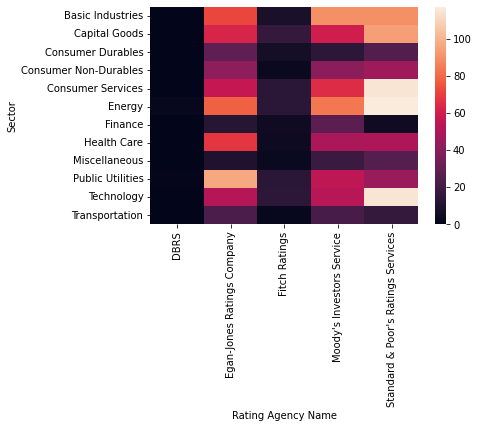

In [51]:
col1 = "Sector"
col2 = "Rating Agency Name"
table = pd.pivot_table(df[[col1, col2]], index=[col1],
                       columns=[col2], aggfunc=len, fill_value=0)
sns.heatmap(table)

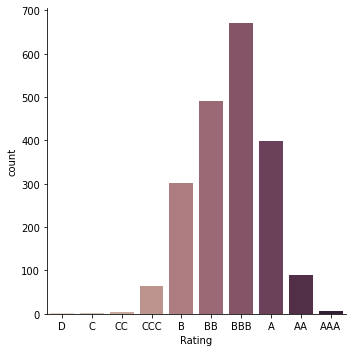

In [52]:
sns.catplot(x="Rating", kind="count", palette="ch:.25", data=df, order=rank)

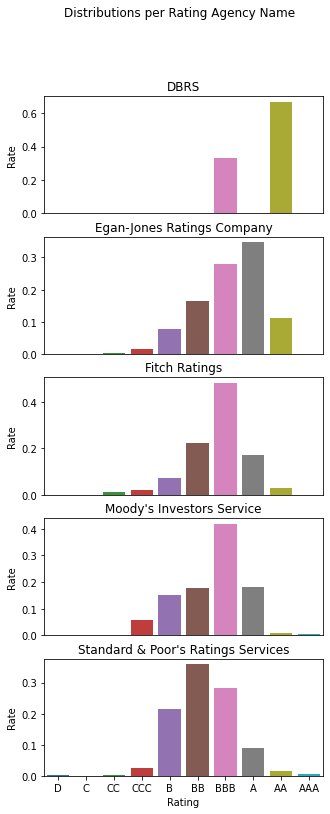

In [53]:
col = col2
dist = df.groupby([col, "Rating"]).agg({
    col : lambda x:x.count()/df[df[col]==x.iloc[0]][col2].count()
})
dist = dist.rename(columns={col:"Rate"})
dist.reset_index(inplace=True)

l = dist[col].unique()
N = len(l)
fig, axes = plt.subplots(nrows=N, sharex=True, figsize=(5, N*2.5))
fig.suptitle(f"Distributions per {col}")
for i in range(N):
  data = dist[dist[col]==l[i]]
  sns.barplot(ax=axes[i], y="Rate", x="Rating", order=rank, data=data)
  if i!= N-1:
    axes[i].axes.get_xaxis().set_visible(False)
  axes[i].set_title(l[i])

**Linear relationships**

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

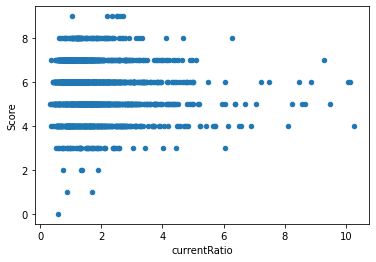

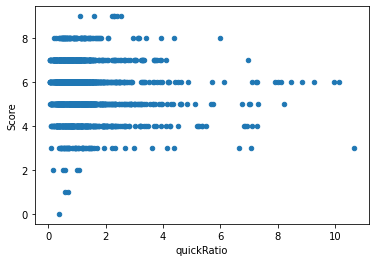

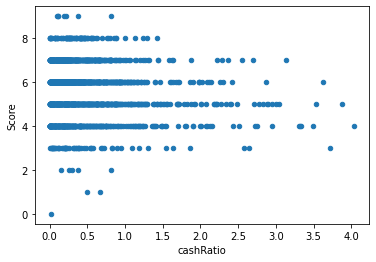

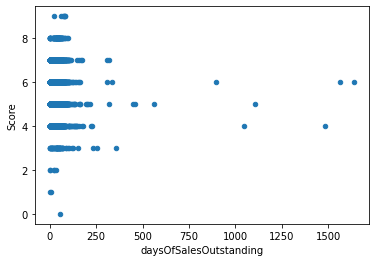

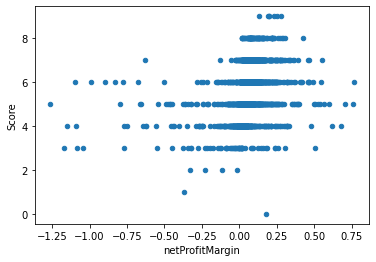

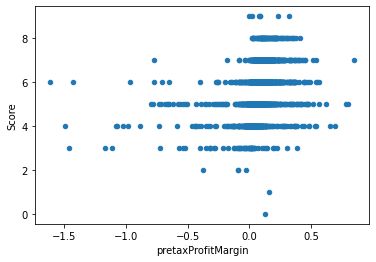

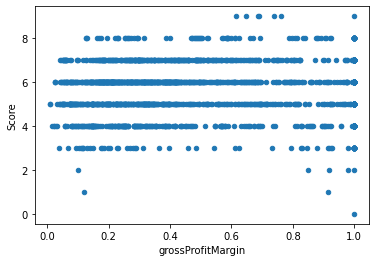

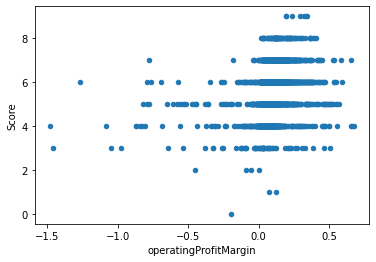

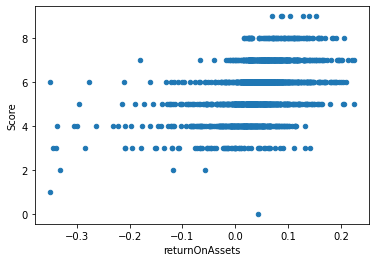

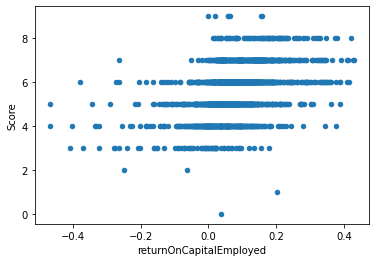

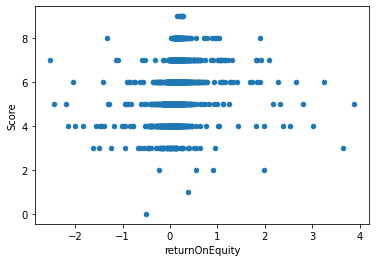

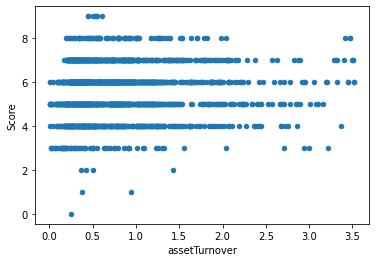

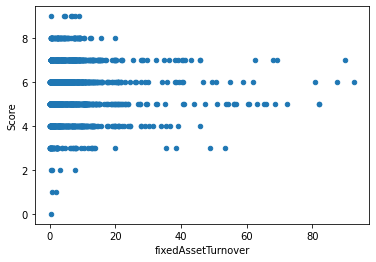

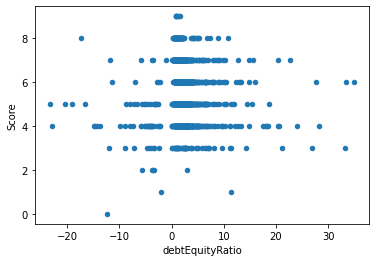

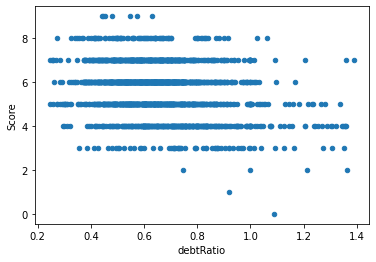

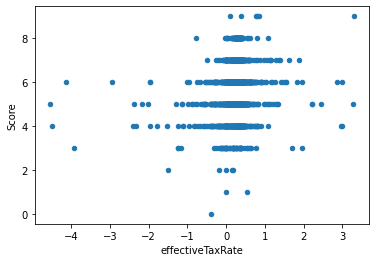

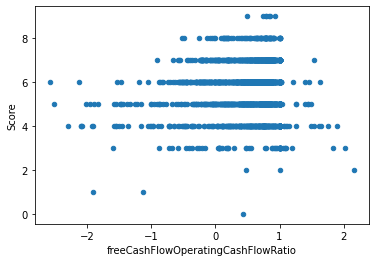

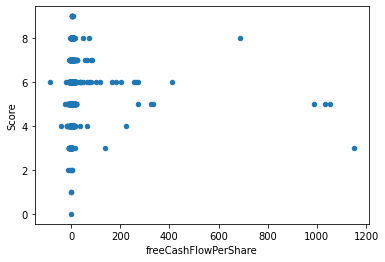

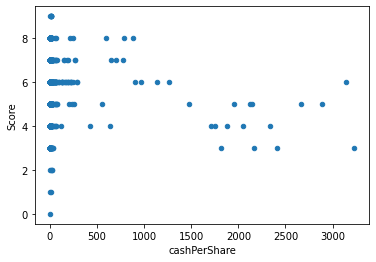

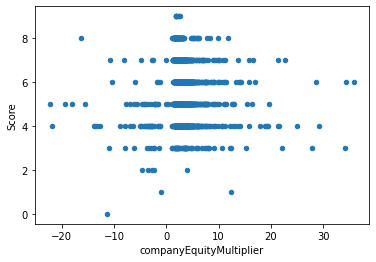

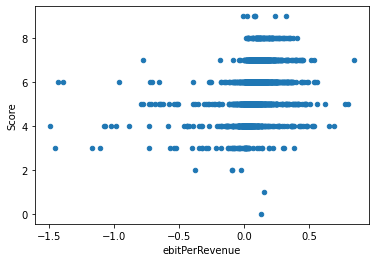

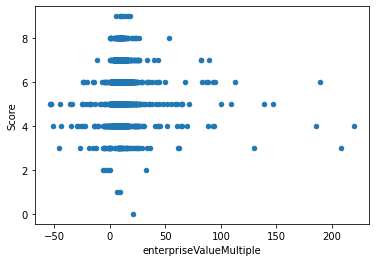

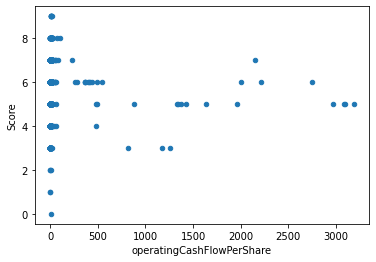

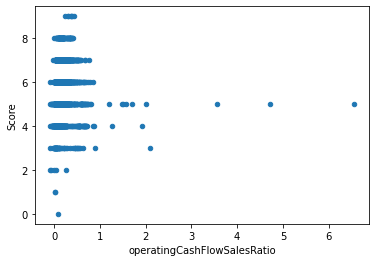

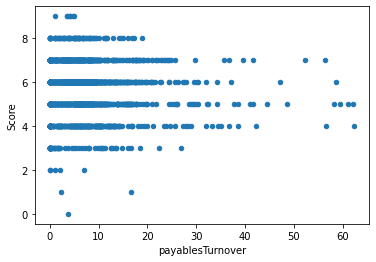

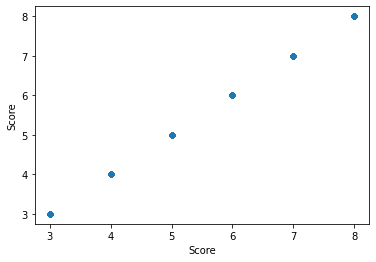

In [54]:
for col in df.describe().columns:
  sup = df[col].quantile(0.99)
  inf = df[col].quantile(0.01)
  data = df[(inf<=df[col]) & (df[col]<=sup)]
  data = data[["Score", col]]
  data.plot.scatter(x=col, y="Score")

**Outlier handling**

In [10]:
for col in df.describe().columns:
  sup = df[col].quantile(0.99)
  inf = df[col].quantile(0.01)
  df[col] = df[col].apply(lambda x:max(x,inf))
  df[col] = df[col].apply(lambda x:min(x,sup))

**Feature selection**

In [11]:
corr = df.corr()["Score"]
numericFeatures = list(corr[abs(corr) >= 0.05].index[:-1])
numericFeatures

['currentRatio',
 'quickRatio',
 'cashRatio',
 'netProfitMargin',
 'pretaxProfitMargin',
 'operatingProfitMargin',
 'returnOnAssets',
 'returnOnCapitalEmployed',
 'returnOnEquity',
 'debtRatio',
 'effectiveTaxRate',
 'freeCashFlowOperatingCashFlowRatio',
 'ebitPerRevenue',
 'enterpriseValueMultiple',
 'operatingCashFlowPerShare']

In [ ]:
numericFeatures = df.describe().columns[:-1]
numericFeatures

**Preprocessing**

In [12]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [13]:
X_numeric = df[numericFeatures].values

scaler = MinMaxScaler(feature_range=(0, 1))
X_numeric = scaler.fit_transform(X_numeric)

categoricalFeatures = ["Rating Agency Name", "Sector"]
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(df[categoricalFeatures]).toarray()

X = np.hstack([X_numeric, X_categorical])
Y = df["Rating"].values

**Imbalance handling - Oversampling**

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
oversampler = RandomOverSampler()
X,Y = oversampler.fit_resample(X,Y)

In [ ]:
print("X:", X.shape)
print("Y:", Y.shape)

data = pd.DataFrame({"Rating":Y})
sns.catplot(x="Rating", kind="count", palette="ch:.25", data=data, order=rank)

**Classifier**

In [17]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

model = RandomForestClassifier()

model.fit(X_train, Y_train)

RandomForestClassifier()

In [19]:
predicted = model.predict(X_test)
print(f"Training accuracy score = {accuracy_score(Y_train, model.predict(X_train))}")
print(f"Test accuracy score = {accuracy_score(Y_test, predicted)}")

# print("Test Confusion matrix\n", confusion_matrix(Y_test, predicted))
print("Test Classification report\n", classification_report(Y_test, predicted))

Training accuracy score = 1.0
Test accuracy score = 0.9053651266766021
Test Classification report
               precision    recall  f1-score   support

           A       0.83      0.87      0.85       119
          AA       0.97      1.00      0.98       149
         AAA       1.00      1.00      1.00       150
           B       0.85      0.93      0.89       137
          BB       0.71      0.65      0.68       138
         BBB       0.65      0.56      0.60       126
           C       1.00      1.00      1.00       126
          CC       1.00      1.00      1.00       117
         CCC       0.98      1.00      0.99       159
           D       1.00      1.00      1.00       121

    accuracy                           0.91      1342
   macro avg       0.90      0.90      0.90      1342
weighted avg       0.90      0.91      0.90      1342



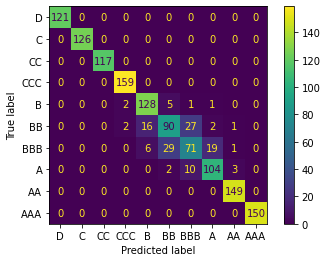

In [20]:
# ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predicted, labels=list(rank.keys()))

**Neural Network**

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Adagrad, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

In [22]:
y = pd.get_dummies(Y)
y = y[rank.keys()].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [23]:
def scheduler(epoch, lr):
  if epoch<100:
    return lr
  else:
    return lr*0.99

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [24]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X.shape[1], kernel_initializer=RandomNormal(stddev=1, seed=40)))
# model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_initializer=RandomNormal(stddev=1, seed=40)))
model.add(Dense(y.shape[1], activation='softmax'))

epochs = 300
learning_rate = 0.01
momentum = 0.1

optimizer = RMSprop(learning_rate=learning_rate, momentum=momentum)

loss = 'categorical_crossentropy'
loss = 'mean_squared_error'

model.compile(optimizer=optimizer,
              loss=loss,
              metrics="accuracy")

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
Total params: 754
Trainable params: 754
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, Y_train, epochs=epochs
                    , callbacks=[callback]
                    )
# history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.2, batch_size=50)

Epoch 1/300
168/168 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.3642 - lr: 0.0100
Epoch 2/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0598 - accuracy: 0.5119 - lr: 0.0100
Epoch 3/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0532 - accuracy: 0.5442 - lr: 0.0100
Epoch 4/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.5745 - lr: 0.0100
Epoch 5/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.5926 - lr: 0.0100
Epoch 6/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.6164 - lr: 0.0100
Epoch 7/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.6237 - lr: 0.0100
Epoch 8/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.6474 - lr: 0.0100
Epoch 9/300
168/168 [==============================] - 0s 1ms/step - loss: 0.0425 - accu

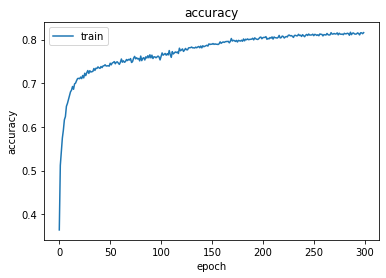

In [27]:
metric = 'loss'
metric = 'accuracy'

plt.plot(history.history[metric])
# plt.plot(history.history[f"val_{metric}"])
plt.title(metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(["train", "test"], loc="upper left")

In [28]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Evaluation score", scores)

predicted = model.predict(X_test)
testActual, testPredicted = np.argmax(Y_test, axis=1), np.argmax(predicted, axis=1)
trainActual, trainPredicted = np.argmax(Y_train, axis=1), np.argmax(model.predict(X_train), axis=1)

print(f"Training accuracy score = {accuracy_score(trainActual, trainPredicted)}")
print(f"Test accuracy score = {accuracy_score(testActual, testPredicted)}")

# print("Test Confusion matrix\n", confusion_matrix(testActual, testPredicted))
print("Test Classification report\n", classification_report(testActual, testPredicted))

Evaluation score [0.03298484534025192, 0.757079005241394]
Training accuracy score = 0.8135245901639344
Test accuracy score = 0.7570789865871833
Test Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       0.98      1.00      0.99       129
           2       0.97      1.00      0.99       136
           3       0.87      0.90      0.89       141
           4       0.65      0.62      0.63       136
           5       0.47      0.44      0.45       128
           6       0.35      0.31      0.33       149
           7       0.56      0.47      0.51       145
           8       0.71      0.93      0.81       118
           9       0.94      1.00      0.97       129

    accuracy                           0.76      1342
   macro avg       0.75      0.77      0.76      1342
weighted avg       0.74      0.76      0.75      1342



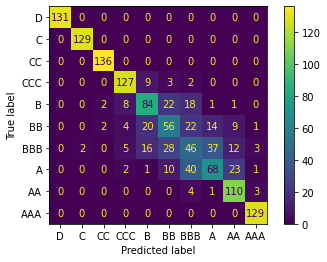

In [29]:
ConfusionMatrixDisplay.from_predictions(testActual, testPredicted, display_labels=list(rank.keys()))

**Linear regression**

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import ElasticNet, BayesianRidge

In [43]:
orderType = "Rank"
# orderType = "Frequency"
df["Score"] = df["Rating"].map(order[orderType])
order["Threshold"] = (order[orderType].shift(-1) + order[orderType])/2

Y_scores = np.vectorize(lambda x:order[orderType].loc[x])(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_scores, test_size=0.2, shuffle=True)

In [44]:
ratings = list(order.index)
thresholds = list(order["Threshold"])
thresholds[-1] = np.Infinity
def decideRating(score):
  for r,t in zip(ratings, thresholds):
    res = r
    if not t:
      return ratings[-1]
    elif score < t:
      return res

In [45]:
# model = ElasticNet(fit_intercept=False)
model = LinearRegression(fit_intercept=False)

model.fit(X_train, Y_train)

predicted = model.predict(X_test)
predictedLabels = np.vectorize(decideRating)(predicted)
reconstructedActualLabels = np.vectorize(decideRating)(Y_test)

predictedTrain = model.predict(X_train)
predictedTrainLabels = np.vectorize(decideRating)(predictedTrain)
reconstructedActualTrainLabels = np.vectorize(decideRating)(Y_train)

In [46]:
print(f"Train Labels accuracy score = {accuracy_score(reconstructedActualTrainLabels, predictedTrainLabels)}")
print(f"Train Scores RMS = {np.sqrt(np.sum((Y_train-predictedTrain)))}")

print(f"Test Labels accuracy score = {accuracy_score(reconstructedActualLabels, predictedLabels)}")
print(f"Test Scores RMS = {np.sqrt(np.sum((Y_test-predicted)))}")

print("Test Classification report\n", classification_report(reconstructedActualLabels, predictedLabels))

Train Labels accuracy score = 0.3440760059612519
Train Scores RMS = nan
Test Labels accuracy score = 0.349478390461997
Test Scores RMS = 3.076630670686804
Test Classification report
               precision    recall  f1-score   support

           A       0.25      0.38      0.30       128
          AA       0.29      0.26      0.27       123
         AAA       0.83      0.18      0.30       130
           B       0.22      0.21      0.21       125
          BB       0.23      0.33      0.27       123
         BBB       0.28      0.40      0.33       159
           C       0.42      1.00      0.59       131
          CC       0.83      0.67      0.74       132
         CCC       0.24      0.11      0.15       145
           D       0.00      0.00      0.00       146

    accuracy                           0.35      1342
   macro avg       0.36      0.35      0.32      1342
weighted avg       0.35      0.35      0.31      1342



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


Train confusion matrix


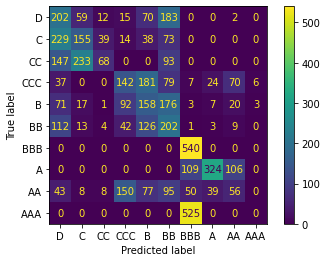

In [47]:
print("Train confusion matrix")
ConfusionMatrixDisplay.from_predictions(reconstructedActualTrainLabels, predictedTrainLabels, display_labels=list(rank.keys()))

Test confusion matrix


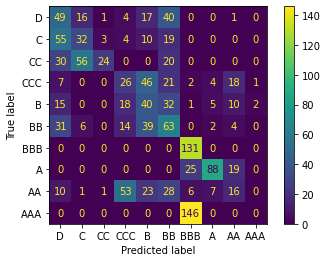

In [48]:
print("Test confusion matrix")
ConfusionMatrixDisplay.from_predictions(reconstructedActualLabels, predictedLabels, display_labels=list(rank.keys()))

In [49]:
model.coef_

array([ -2.71808686,   1.77272462,  -1.44458799,  -3.42211544,
         3.30133987,  11.23122936,   1.19754181,   4.39458268,
         2.24536213,  -4.88140391,   0.06930389,   1.57710867,
       -15.5491781 ,  -1.09199477,  -0.44901538,   5.95333309,
         3.38238951,   3.10488984,   2.34811698,   2.49082161,
         1.01155342,   1.65696241,   1.07547234,   1.3048164 ,
         0.61685506,   0.74658301,   0.80569772,   1.79403856,
         1.55009606,   2.36874352,   2.49367439,   1.85505814])

In [50]:
model.intercept_

0.0